# Bonus Lab: Kalman Filtering

Parameter estimation for robotics can be challenging due to noisy sensor data and inexact motion models. Kalman filtering is a technique that uses properties of the **Gaussian distribution** to minimize error in the state of an agent. The Kalman filter uses a motion model to predict the future state of the agent, and corrects these predictions based on sensor measurements with **Bayes Theorem**.

In this notebook, we will learn how to use kalman filtering to more effectively estimate the state of the RACECAR. Here, you will estimate the distance of an orange cone, as you did in Lab 3b.

Throughout this notebook, **<font style="color:red">text in bold red</font>** indicates a change you must make to the following code block before running it.


## Table of Contents
1. [Getting Started](#GettingStarted)
2. [Depth and Color Images](#DepthAndColorImages)
3. [Uncertainty](#Uncertainty)
4. [Prediction](#Prediction)
5. [Implementation](#Implementation)

<a id="GettingStarted"></a>
## 1. Getting Started

**<font style="color:red">If you are running the car in RacecarSim, set `isSimulation` to `True`</font>**. Leave `isSimulation` `False` if you are using a physical car.

In [1]:
# TODO: Update isSimulation if necessary
isSimulation = True

Next, we will import the necessary libraries for this notebook, including Python libraries (`cv`, `numpy`, etc.) and the Racecar library (`racecar_core`).

In [2]:
# Import Python libraries
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import statistics
from nptyping import NDArray
from typing import Any, Tuple, List, Optional

# Import Racecar library
import sys
sys.path.append("../../library")
import racecar_core
import racecar_utils as rc_utils

The following functions will help us throughout this notebook.

In [3]:
def show_depth_image(
    depth_image: NDArray[(Any, Any), np.float32],
    max_depth: int = 400,
    points: List[Tuple[int, int]] = []
) -> None:
    """
    Displays a color image in the Jupyter Notebook.
    
    Args:
        depth_image: The image to display.
        max_depth: The farthest depth to show in the image in cm. Anything past this depth is shown as black.
        points: A list of points in (pixel row, pixel column) format to show on the image colored dots.
    """
    # Clip anything above max_depth
    np.clip(depth_image, None, max_depth, depth_image)

    # Shift down slightly so that 0 (no data) becomes the "farthest" color
    depth_image = (depth_image - 1) % max_depth

    # Convert depth values to colors
    color_image = cv.applyColorMap(-cv.convertScaleAbs(depth_image, alpha=255/max_depth), cv.COLORMAP_INFERNO)
    
    # Draw a dot at each point in points
    for point in points:
        cv.circle(color_image, (point[1], point[0]), 6, (0, 255, 0), -1)

    # Show the image with Matplotlib
    plt.imshow(cv.cvtColor(color_image, cv.COLOR_BGR2RGB))
    plt.show()


def add_noise(
    depth_image: NDArray[(Any, Any), np.float32],
    error_percent = 0.1,
    null_percent: float = 0.005
) -> NDArray[(Any, Any), np.float32]:
    """
    Adds noise to a depth image.
    
    Args:
        depth_image: The original image to which to add noise.
        error_percent: The error percentage to introduce to each measurement.
        null_percent: The percentage of pixels to set to zero.
    
    Returns:
        A copy of the provided depth_image with noise added.
    """
    # Copy the original image
    image = np.copy(depth_image) 
    
    # Apply error_percent to each measurement (gaussian error)
    gauss = np.random.normal(1, error_percent, image.shape)
    image *= gauss
    
    # Add null (zero) values
    num_nulls = int(image.size * null_percent)
    coords = [np.random.randint(0, i - 1, num_nulls) for i in image.shape]
    image[tuple(coords)] = 0.0
    
    return image


def crop(
    image: NDArray[(Any, ...), Any],
    top_left_inclusive: Tuple[float, float],
    bottom_right_exclusive: Tuple[float, float]
) -> NDArray[(Any, ...), Any]:
    """
    Crops an image to a rectangle based on the specified pixel points.

    Args:
        image: The color or depth image to crop.
        top_left_inclusive: The (row, column) of the top left pixel of the crop rectangle.
        bottom_right_exclusive: The (row, column) of the pixel one past the bottom right corner of the crop rectangle.

    Returns:
        A cropped version of the image.

    Note:
        The top_left_inclusive pixel is included in the crop rectangle, but the
        bottom_right_exclusive pixel is not.
        
        If bottom_right_exclusive exceeds the bottom or right edge of the image, the
        full image is included along that axis.
    """
    # Extract the minimum and maximum pixel rows and columns from the parameters
    r_min, c_min = top_left_inclusive
    r_max, c_max = bottom_right_exclusive

    # Shorten the array to the specified row and column ranges
    return image[r_min:r_max, c_min:c_max]

Finally, we will create a racecar object.  If this step fails, make sure that `isSimulation` has the correct value.

In [4]:
# Create Racecar
rc = racecar_core.create_racecar(isSimulation)

>> Racecar created with the following options:
    Simulation (-s): [True]
    Headless (-h): [False]
    Initialize with display (-d): [False]


<a id="DepthAndColorImages"></a>
## 2. Depth and Color Images
The following code has been provided for idenitfying an orange contour and calculating its distance.

In [5]:
# The HSV range for the color orange
ORANGE = ((90, 50, 50), (120, 255, 255))

# Calculate the center of the contour
def find_contour_center():
    contour_center = None
    
    image = rc.camera.get_color_image_async()
    
    # Find all of the orange contours
    contours = rc_utils.find_contours(image, ORANGE[0], ORANGE[1])

    # Select the largest contour
    contour = rc_utils.get_largest_contour(contours, 30)
    
    if contour is not None:
        # Calculate contour information
        contour_center = rc_utils.get_contour_center(contour)
        return (contour_center[1],contour_center[0])

<a id="Uncertainty"></a>
## 3. Uncertainty

While it is easy to estimate state based on raw sensor, these measurements are inherently noisy. Oftentimes, this noise follows a Gaussian, or normal distribution. The Kalman filter uses properties of this distribution to optimally estimate the state of an agent.

Probability distributions have an associated variance, or spread of the values (you may remember this as the square of the standard deviation). The more noisy sensor data, the greater its variance. The Kalman filter uses known information about the variance, or uncertainty, of sensor measurements to make accurate estimates.

The variance of a sample of data can be computed using:
$\sigma^2 = \frac{\sum (x_i -\overline{x})^2}{n-1}$

Here, you will calculate the variance of a sample of depth measurements on an orange cone:

**<span style="color:red">Finish writing `get_sample_variance` in the following code block.</span>**

Note: you might have seen the that sample variance has $n-1$ in the denominator, as opposed to $n$. This has to do with the fact that the values in a sample will inherently be closer to the sample mean than the actual mean. Read up on **sampling** if you're further curious on why this value takes on $n-1$ specifically.

In [7]:
depth_data = []

#collect data
for i in range(30):
    
    #find contour
    contour_center = find_contour_center()
    
    if contour_center is not None:
        #compute distance
        depth_image = rc.camera.get_depth_image_async()
        z = rc_utils.get_pixel_average_distance(depth_image, contour_center)
        print(z)
        depth_data.append(z)
    
def get_sample_variance(data):
    
    #TODO: calculate the sample variance on the depth data
    
sample_variance = get_sample_variance(depth_data)
print("sample variance: ", sample_variance)

104.035675
105.42071
106.33837
105.067
105.92013
103.50241
105.27675
103.56479
110.32463
103.72267
110.124626
104.4324
105.0116
101.140976
103.96829
103.28456
106.45598
100.99677
104.54126
103.37908
107.57448
104.58403
104.43553
101.70653
109.26831
103.62463
104.971886
107.06133
102.84172
105.26291
sample variance:  3


You will notice that the depth measurements vary even thought the actual distance does not change

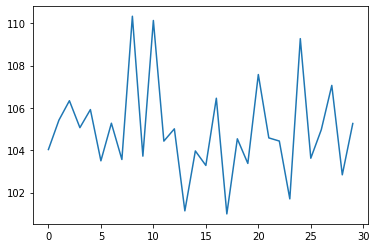

In [8]:
plt.plot(depth_data)
plt.show()

<a id="Prediction"></a>
## 4. Prediction

The Kalman filter makes **predictions** of the RACECAR's state each timestep based on sensor measurements and their **uncertainty**. 

There is uncertainty in this prediction ($\sigma_{\hat{x}}$), as well as the sensor measurements ($\sigma_{\hat{z}}$). However, while the sensor measurements maintain a consistent uncertainty inherent to the sensor, the uncertainty of the prediction will decrease as more and more measurements are made.

Here, you will use Kalman filtering to estimate the distance of the orange cone while stationary ($x$). You will need to implement the following formulas:

**Kalman gain**: $K=\frac{\hat{\sigma}_{\hat{x}}^2}{\hat{\sigma}_{\hat{x}}^2+\sigma_z^2}$

The Kalman gain capture the relative accuracy of the estimate, and is calculated by dividing the estimate uncertainty ($\hat{\sigma}_{\hat{x}}^2$) by itself added to the measurement uncertainty ($\hat{\sigma}_{\hat{x}}^2+\sigma_z^2$). This value will always be less than 1, so every timestep, as the RACECAR gains more and more data, the Kalman gain should go down. 

**Distance estimate**: $x=\hat{x}+K*(z-\hat{x})$

This is how far the RACECAR thinks the cone is. It adjusts the prediction $\hat{x}$ based on the sensor measurement ($z$).

Updated **estimate uncertainty**: $ \sigma_{\hat{x}}^2 = (1-K) * \sigma_{\hat{x}}^2 $

This is how uncertain the RACECAR is about its estimate. Every timestep, uncertainty should decrease ($0 \leq K \leq 1$).

**<span style="color:red">Estimate the distance of an orange cone while the robot is stationary by computing the Kalman gain, distance estimate, and estimate uncertainty</span>**

NOTE: because the RACECAR is stationary, your prediction ($\hat{x}$) will be the same as your previous estimate ($x$).

Hint: You calculated uncertainty in the sensor measurement during the previous section

In [10]:
# Initial prediction
predicted_distance = 100
# Initial uncertainty
estimate_variance = 400

depth_data = []
estimates = []

for i in range(30):
    
    #find contour
    contour_center = find_contour_center()
    
    if contour_center is not None:
        #compute distance
        depth_image = rc.camera.get_depth_image_async()
        z = rc_utils.get_pixel_average_distance(depth_image, contour_center)
        print(z)
        depth_data.append(z)
    
    
    #TODO: compute the Kalman gain
    K = 
    
    #TODO: estimate the distance from the cone
    estimate = 
    
    estimates.append(estimate)
    
    #Estimate uncertainty
    estimate_uncertainty = 

105.05846
102.84233
108.74164
105.1827
105.37468
105.865036
105.91574
108.13771
104.39417
100.8343
106.121254
109.21776
104.27721
108.25184
103.85033
108.18071
104.00426
101.685486
100.67201
103.40814
107.57622
104.60262
103.373795
105.02775
100.17612
107.28107
106.34128
105.4633
104.74989
103.12167


Your program should stabilize the distance predictions over time!

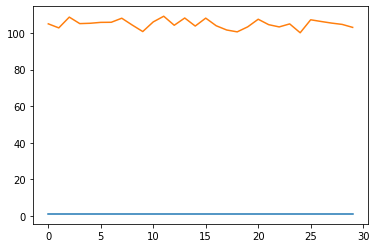

In [12]:
signal = plt.plot(estimates)
signal = plt.plot(depth_data)

<a id="Implementation"></a>
## 5. Implementation

Congrats, You've completed this Jupyter Notebook!

This section will outline how to transform the Kalman filter you designed to work while the RACECAR is in motion. Unfortunately, Jupyter Notebook doesn't have a way to measure $\Delta$time, so **the provided starter code is only an example of what you might write in your IDE/text editor. The code will not work in Jupyter Notebook**. Try implementing this in one of your previous programs, or test it out as is.

Most of the time when you want to estimate the state of the RACECAR it will be in motion. This means the Kalman filter prediction will need to incorporate **velocity** and **acceleration** which both have their own measurement uncertainties.

You can calculate calculate these values using sampling in the same way you did for distance. Here they are provided for you to save time/effort.

In [ ]:
acceleration_variance = 112
velocity_variance = 112

Now, you will incorporate implement Kalman filter while the RACECAR is accelerating. Here, you will have to incorporate a **motion model** to predict the new state of the RACECAR each timestep. All requisite equations are provided: 


**predicted state**: $\hat{x}=x + \Delta t v + \frac{1}{2}\Delta t^2 a$

This equation is **new**. Unlike in the previous example, the RACECAR is accelerating, so you will need to predict a new location for the RACECAR each timestep based on its velocity and acceleration.

**estimate uncertainty**: $\hat{\sigma}_{\hat{x}}^2=\sigma_x^2+\Delta t \sigma_v^2 + \frac{1}{2}\Delta t^2 \sigma_a^2$

**kalman gain**: $K=\frac{\hat{\sigma}_{\hat{x}}^2}{\hat{\sigma}_{\hat{x}}^2+\sigma_z^2}$ 

**estimate**: $x=\hat{x}+K(z-\hat{x})$


**<span style="color:red">Estimate the distance of an orange cone while the robot is accelerating</span>**

**<span style="color:red">Use controls in the sim to accelerate and decelerate while keeping the cone in view</span>**

Hint: compute velocity and acceleration using rc.get_delta_time()

In [13]:
# Initial prediction
predicted_distance = 100
# Initial uncertainty
estimate_variance = 400

depth_data = []
estimates = []

for i in range(20):
    #find contour
    contour_center = find_contour_center()
    
    if contour_center is not None:
        #compute distance
        depth_image = rc.camera.get_depth_image_async()
        z = rc_utils.get_pixel_average_distance(depth_image, contour_center)
    
    depth_data.append(z)
    
    #TODO: predict the distance of the cone based on previous estimate
    v = 
    a = 
    x = 
    
    #TODO: estimate the distance from the cone
    estimate = 
    
    estimates.append(estimate)
    
    #TODO: estimate uncertainty
    estimate_uncertainty = 
    
    #TODO: compute a new Kalman gain
    K = 